#Import nessessary libraries 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, RNN, TimeDistributed, GRU
from tensorflow.keras import optimizers

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import MinMaxScaler

import keras

#Data

In [2]:
def generate_time_series(num_of_sample, second):

    freq1, freq2, freq3, freq4, offs1, offs2, offs3, offs4 = np.random.rand(8, 1)
    time = np.linspace(0, second, num_of_sample)

    wave1 = 0.5 * np.sin((time - offs1) * (freq1 * 10 + 10))  
    wave2 = 0.2 * np.sin((time - offs2) * (freq2 * 20 + 20)) 
    wave3 = - 0.7 * np.sin((time - offs3) * (freq2 * 30 + 30)) 
    wave4 = 0.6 * np.sin((time - offs4) * (freq2 * 40 + 40)) 
    
    noise = 0.1 * (np.random.rand(1, num_of_sample) - 0.5)  

    data = wave1 + wave2 + wave3 + wave4 + noise
    return data

def split_sequence(sequence, window_length):
  X, y = list(), list()

  for i in range(0, len(sequence) - window_length):
    X_temp, y_temp = sequence[i : i + window_length], sequence[i + window_length]

    X.append(X_temp)
    y.append(y_temp)

  return np.asarray(X), np.asarray(y)    

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label = "Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def plot_yt_ypred(y_test, y_pred, label1, label2):
    plt.figure(figsize = (8,6))
    plt.plot(y_test,'-', label = label1)
    plt.plot(y_pred,'-rx', label = label2)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
np.random.seed(1010)
num_of_sample = 10000
data = generate_time_series(num_of_sample, 10)

training_data = data[:, :9000]
test_data = data[:, 9000:]

my_scaler = MinMaxScaler()
training_data_scaled = my_scaler.fit_transform(training_data.reshape(-1, 1))
test_data_scaled = my_scaler.transform(test_data.reshape(-1, 1))

window = 50

training_data_scaled = training_data_scaled.reshape(-1, 1)
X_train_total, y_train_total = split_sequence(training_data_scaled, window)

print("Size of X_train_total: ", X_train_total.shape)
print("Size of y_train_total: ", y_train_total.shape)

test_data_scaled = test_data_scaled.reshape(-1, 1)
X_test, y_test = split_sequence(test_data_scaled, window)

print("Size of X_test: ", X_test.shape)
print("Size of y_test: ", y_test.shape)

X_train = X_train_total[:7000, :, :]
y_train = y_train_total[:7000, :]

X_val = X_train_total[7000:, :, :]
y_val = y_train_total[7000:, :]

print("Size of X_train: ", X_train.shape)
print("Size of y_train: ", y_train.shape)
print("Size of X_val: ", X_val.shape)
print("Size of y_val: ", y_val.shape)

Size of X_train_total:  (8950, 50, 1)
Size of y_train_total:  (8950, 1)
Size of X_test:  (950, 50, 1)
Size of y_test:  (950, 1)
Size of X_train:  (7000, 50, 1)
Size of y_train:  (7000, 1)
Size of X_val:  (1950, 50, 1)
Size of y_val:  (1950, 1)


#Model1: One layer of LSTM(units = 10)


##Define the model

In [17]:
model1 = Sequential()
model1.add(LSTM(10, activation='relu', input_shape=(50,1)))
model1.add(Dense(1))  
optimizer = optimizers.Adam(learning_rate = 0.005)
model1.compile(loss = "mse", optimizer = optimizer)

##Explore the weights

In [18]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [19]:
print("Length of weights of model1 = ", len(model1.get_weights()))

Length of weights of model1 =  5


In [20]:
print(model1.get_weights()[0].shape)
print(model1.get_weights()[1].shape)
print(model1.get_weights()[2].shape)
print(model1.get_weights()[3].shape)
print(model1.get_weights()[4].shape)

(1, 40)
(10, 40)
(40,)
(10, 1)
(1,)


In [21]:
W_x = model1.get_weights()[0]
W_h = model1.get_weights()[1]
b_h = model1.get_weights()[2]

print("Size of W_x = ", W_x.shape)
print("Size of W_h = ", W_h.shape)
print("Size ofb_h = ", b_h.shape)

Size of W_x =  (1, 40)
Size of W_h =  (10, 40)
Size ofb_h =  (40,)


In [22]:
W_y = model1.get_weights()[3]
b_y = model1.get_weights()[4]

print("Size of W_y = ", W_y.shape)
print("Size of b_y = ", b_y.shape)

Size of W_y =  (10, 1)
Size of b_y =  (1,)


<font color='red'>Explain what you see. Some questions you may ask yourself </font>

<font color='red'> - Why do we have those sizes? </font>

<font color='red'> - Where are those matrices in the network? </font>


##Train the model

In [23]:
history1 = model1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/20
219/219 [==============================] - 29s 123ms/step - loss: 0.0245 - val_loss: 4.4552e-04
Epoch 2/20
219/219 [==============================] - 27s 122ms/step - loss: 3.3897e-04 - val_loss: 2.5838e-04
Epoch 3/20
219/219 [==============================] - 26s 120ms/step - loss: 2.2057e-04 - val_loss: 2.0083e-04
Epoch 4/20
219/219 [==============================] - 27s 123ms/step - loss: 1.7186e-04 - val_loss: 1.7648e-04
Epoch 5/20
219/219 [==============================] - 26s 119ms/step - loss: 1.4278e-04 - val_loss: 1.3113e-04
Epoch 6/20
219/219 [==============================] - 26s 119ms/step - loss: 1.2809e-04 - val_loss: 1.2346e-04
Epoch 7/20
219/219 [==============================] - 26s 120ms/step - loss: 1.1358e-04 - val_loss: 1.0523e-04
Epoch 8/20
219/219 [==============================] - 27s 121ms/step - loss: 1.0832e-04 - val_loss: 9.5657e-05
Epoch 9/20
219/219 [==============================] - 26s 120ms/step - loss: 1.0299e-04 - val_loss: 9.7841e-05
Epoch

###Learning curve

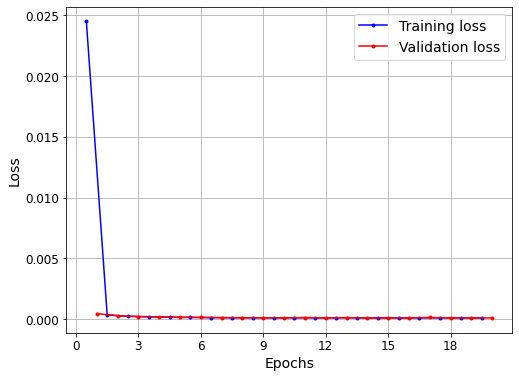

In [24]:
plot_learning_curves(history1.history["loss"], history1.history["val_loss"])

###RMSE

In [25]:
y_pred_model1 = model1.predict(X_test)

rmse_model1 = np.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred_model1)))
print("RMSE of model1 = ", rmse_model1)

RMSE of model1 =  0.00949641


### `y_test` versus `y_pred`

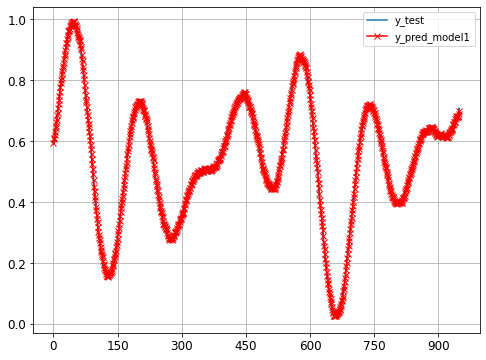

In [26]:
plot_yt_ypred(y_test, y_pred_model1, 'y_test', 'y_pred_model1')

#Model2: LSTM $\longrightarrow$ LSTM $\longrightarrow$ Dense

LSTM layers: `units = 10`

###Define the model

In [28]:
model2 = Sequential()
model2.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(50,1)))
model2.add(LSTM(10, activation='relu'))
model2.add(Dense(1))  
optimizer = optimizers.Adam(learning_rate = 0.005)
model2.compile(loss = "mse", optimizer = optimizer)

###Explore the weights

In [29]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50, 10)            480       
                                                                 
 lstm_8 (LSTM)               (None, 10)                840       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [30]:
print("Length of weights of model2 = ", len(model2.get_weights()))

Length of weights of model2 =  8


In [31]:
print("Size of weights in model2:\n")
print(model2.get_weights()[0].shape)
print(model2.get_weights()[1].shape)
print(model2.get_weights()[2].shape)
print(" ")
print(model2.get_weights()[3].shape)
print(model2.get_weights()[4].shape)
print(model2.get_weights()[5].shape)
print(" ")
print(model2.get_weights()[6].shape)
print(model2.get_weights()[7].shape)

Size of weights in model2:

(1, 40)
(10, 40)
(40,)
 
(10, 40)
(10, 40)
(40,)
 
(10, 1)
(1,)


<font color='red'>Explain what you see. Some questions you may ask yourself </font>

<font color='red'> - Why do we have those sizes? </font>

<font color='red'> - Where are those matrices in the network? </font>


###Train the model

In [32]:
history2 = model2.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/20
219/219 [==============================] - 56s 244ms/step - loss: 0.0232 - val_loss: 5.1193e-04
Epoch 2/20
219/219 [==============================] - 53s 241ms/step - loss: 3.4134e-04 - val_loss: 2.6339e-04
Epoch 3/20
219/219 [==============================] - 52s 239ms/step - loss: 2.2148e-04 - val_loss: 1.8251e-04
Epoch 4/20
219/219 [==============================] - 53s 241ms/step - loss: 1.6581e-04 - val_loss: 2.6911e-04
Epoch 5/20
219/219 [==============================] - 53s 242ms/step - loss: 1.5035e-04 - val_loss: 1.4839e-04
Epoch 6/20
219/219 [==============================] - 53s 241ms/step - loss: 1.2850e-04 - val_loss: 1.2421e-04
Epoch 7/20
219/219 [==============================] - 53s 241ms/step - loss: 1.2651e-04 - val_loss: 1.0280e-04
Epoch 8/20
219/219 [==============================] - 53s 240ms/step - loss: 1.2037e-04 - val_loss: 1.2309e-04
Epoch 9/20
219/219 [==============================] - 53s 240ms/step - loss: 1.1313e-04 - val_loss: 1.4706e-04
Epoch

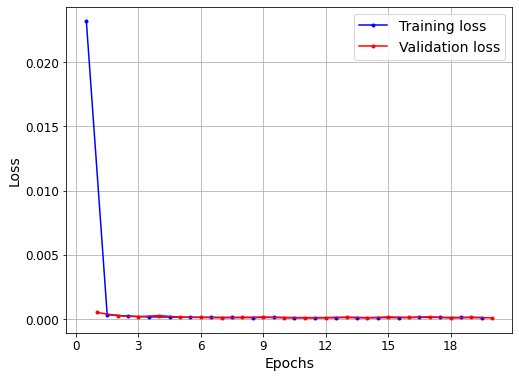

In [33]:
plot_learning_curves(history2.history["loss"], history2.history["val_loss"])

In [34]:
y_pred_model2 = model2.predict(X_test)

rmse_model2 = np.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred_model2)))
print("RMSE of model2 = ", rmse_model2)

RMSE of model2 =  0.009451787


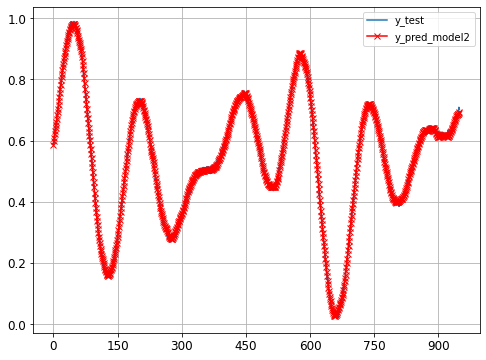

In [35]:
plot_yt_ypred(y_test, y_pred_model2, 'y_test', 'y_pred_model2')